# Compare Runs
Compare different configurations for models

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from mlflow.artifacts import load_text
from mlflow import MlflowClient
import pandas as pd

## Pull Runs from MLFlow
ML flow uses local storage in the `mlruns` directory

In [2]:
client = MlflowClient()

In [3]:
def gather_run_summaries(exp_name: str = '0') -> list[dict]:
    """Get all runs for a certain experiment
    
    Pulls the metrics, parameters, tags, and the artifact URI (so we can download data later).
    
    Args:
        exp_name: Name of the experiment.
    Returns:z
        List of dictionaries describing each run
    """
    
    output = []
    for run in client.search_runs(exp_name):
        record = run.data.tags
        record.update((f'metrics.{k}'.replace(" ", "_"), v) for k, v in run.data.metrics.items())
        record.update((f'params.{k}'.replace(" ", "_"), v) for k, v in run.data.params.items())
        record['artifact.uri'] = run.info.artifact_uri
        record['id'] = run.info.run_id
        output.append(record)
    return output

In [4]:
summary = pd.DataFrame(gather_run_summaries())

## Evaluate Best Model
See the best model on the train files for the 64-water MD simulation

In [5]:
train_files = "['../0_setup/md/packmol-CH4-in-H2O=32-seed=129-blyp-npt=298/md.traj']"

In [6]:
only_64 = summary[summary['params.train_files'] == train_files]
best_run = only_64.sort_values('metrics.force-rmse', ascending=True).iloc[0]

Pull out the parameters

In [7]:
params = dict((k[7:], v) for k, v in best_run.to_dict().items() if k.startswith('params.'))
params

{'loss_weights': '(1, 10, 100)',
 'cuda_version': '12.1',
 'pytorch_version': '2.2.2+cu121',
 'val_frac': '0.1',
 'ignite_version': '0.5.0.post2',
 'unfreeze_layers': "('readouts',)",
 'model_size': 'small',
 'learning_rate': '0.0001',
 'device_name': 'NVIDIA GeForce RTX 3070 Ti',
 'batch_size': '4',
 'num_epochs': '32',
 'model_type': 'mace_mp',
 'model': 'ScaleShiftMACE',
 'test_files': 'None',
 'loss_huber': '0.01',
 'train_files': "['../0_setup/md/packmol-CH4-in-H2O=32-seed=129-blyp-npt=298/md.traj']",
 'model_dtype': 'float32'}

Plot the error as a function of timestep

In [8]:
preds = pd.read_csv(f"{best_run['artifact.uri']}/output.csv.gz")
preds['energy_error'] = preds['dft'] - preds['ml']

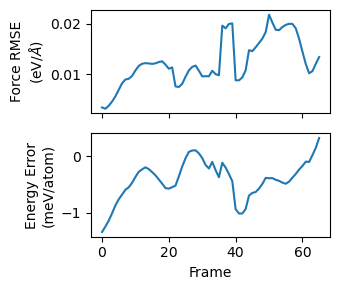

In [9]:
fig, axs = plt.subplots(2, 1, figsize=(3.5, 3.), sharex=True)

axs[0].plot(preds.rmse)
axs[0].set_ylabel('Force RMSE\n(eV/$\\AA$)')

axs[1].plot(preds.energy_error * 1000)
axs[1].set_ylabel('Energy Error\n(meV/atom)')

axs[1].set_xlabel('Frame')

fig.tight_layout()

Plot the training curve

In [10]:
train_log = {}
for metric in ['energy-mae', 'force-rmse']:
    train_log[metric] = [x.value for x in client.get_metric_history(best_run['id'], metric)]
train_log = pd.DataFrame(train_log)    

Text(0.5, 0, 'Epoch')

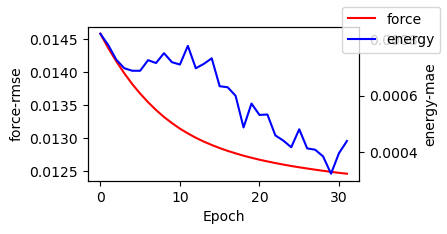

In [11]:
fig, ax = plt.subplots(figsize=(3.5, 2.))

ax2 = ax.twinx()
for a, c, color in zip([ax, ax2], ['force-rmse', 'energy-mae'], ['red', 'blue']):
    a.plot(train_log[c], color=color, label=c.split("-")[0])
    a.set_ylabel(c)

fig.legend()
ax.set_label('Loss')
ax.set_xlabel('Epoch')